# Import & show data

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import FastText
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.neighbors import NearestNeighbors

ModuleNotFoundError: No module named 'bs4'

In [ ]:
df = pd.read_csv('../data/Questions.csv', encoding = "ISO-8859-1", nrows=30000, usecols=['Id', 'Title', 'Body'])
df.shape

(30000, 3)

In [ ]:
#Let's take a look at some of the questions
print('Question1: ', df.iloc[0, 2])
print('Question2: ', df.iloc[1, 2])
print('Question3: ', df.iloc[2, 2])

Question1:  <p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>

<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>

<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>

<ul>
<li>Some Photoshop javascript</li>
<li>A Python function</li>
<li>An OSX API that I can call from python</li>
</ul>

Question2:  <p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

Question3:  <p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending 

# Preprocessing

In [ ]:
#Using beautiful soup to grab text inside 'p' tags and concatenate it
def get_question(html_text):
  soup = BeautifulSoup(html_text, 'lxml')
  question = ' '.join([t.text for t in soup.find_all('p')]) #concatenating all p tags
  return question

#Transforming questions to list for ease of processing
question_list = df['Body'].apply(get_question).values.tolist()

In [ ]:
question_list[0]

"I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of:"

In [ ]:
#Tokenizing with simple preprocess gensim's simple preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # returns lowercase tokens, ignoring tokens that are too short or too long

question_words = list(sent_to_words(question_list))

In [ ]:
question_words[0][0:10] #first 10 questions tokens

['am', 'using', 'the', 'photoshop', 'javascript']

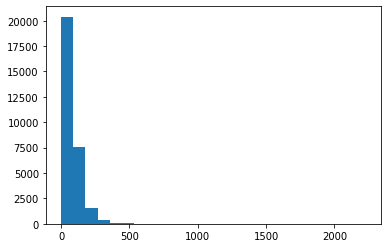

Mean word count of questions is 80.7959


In [ ]:
lengths = [len(question) for question in question_words]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [ ]:
#Getting rid of stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(sentence):
  filtered_words = [word for word in sentence if word not in stop_words]
  return filtered_words

filtered_questions = [remove_stopwords(question) for question in question_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


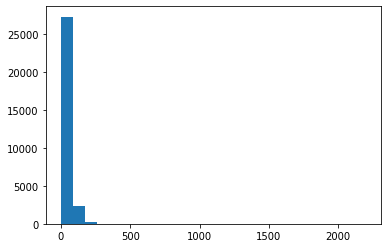

Mean word count of questions is 43.86006666666667


In [ ]:
#Examining word counts after removal of stop words

lengths = [len(question) for question in filtered_questions]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [ ]:
len(filtered_questions)

30000

# Word2Vec

In [ ]:
#Instantiating the model
n = 50
model = Word2Vec(filtered_questions, size = n, window = 8)

#Training model using questions corpora
model.train(filtered_questions, total_examples=len(filtered_questions), epochs=10)

(11639760, 13158020)

In [ ]:
#Let's see how it worked
word_vectors = model.wv

print('Words similar to "array" are: ', word_vectors.most_similar(positive='array'))
print('Words similar to "database" are: ', word_vectors.most_similar(positive='database'))

Words similar to "array" are:  [('arrays', 0.8357066512107849), ('matrix', 0.7622703313827515), ('slice', 0.7567591667175293), ('vector', 0.7039409279823303), ('numpy', 0.6967165470123291), ('dimension', 0.6925920248031616), ('vals', 0.686007022857666), ('dtype', 0.6793662309646606), ('dimensional', 0.6712194681167603), ('tuples', 0.6558892130851746)]
Words similar to "database" are:  [('db', 0.858535647392273), ('postgres', 0.7534809112548828), ('postgresql', 0.7294078469276428), ('tables', 0.7065738439559937), ('databases', 0.6823951005935669), ('mysql', 0.6806763410568237), ('mongodb', 0.6664717793464661), ('sql', 0.6640252470970154), ('sqlite', 0.6639286875724792), ('orm', 0.6571938991546631)]


# Fast Text

In [ ]:
ft_model = FastText(filtered_questions, size=n, window=8, min_count=5, workers=2,sg=1)

In [ ]:
print('Words similar to "array" are: ', ft_model.wv.most_similar('array'))
print('Words similar to "database" are: ', ft_model.wv.most_similar('database'))

Words similar to "array" are:  [('my_array', 0.9272624254226685), ('arrays', 0.9211681485176086), ('ndarray', 0.9200512766838074), ('recarray', 0.9138766527175903), ('asarray', 0.9136890172958374), ('arraylist', 0.8996505737304688), ('bitarray', 0.8525915741920471), ('dimension', 0.8439395427703857), ('dimensional', 0.8217208385467529), ('numpy', 0.8197433948516846)]
Words similar to "database" are:  [('databases', 0.9428731799125671), ('db', 0.8704733848571777), ('postgres', 0.8667688965797424), ('database_engine', 0.8575925230979919), ('dbs', 0.8470574617385864), ('postgresql', 0.8461211919784546), ('zodb', 0.8417341709136963), ('psql', 0.8377990126609802), ('innodb', 0.8186637163162231), ('mssql', 0.8179753422737122)]


## TF-IDF

In [ ]:
dct = Dictionary(filtered_questions)  # fit dictionary
corpus = [dct.doc2bow(line) for line in filtered_questions]  # convert corpus to BoW format
tfidf_model = TfidfModel(corpus)  # fit model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(question_list)
print(X.shape)

(30000, 46433)


In [ ]:
#To proprely work with scikit's vectorizer
merged_questions = [' '.join(question) for question in filtered_questions]
document_names = ['Doc {:d}'.format(i) for i in range(len(merged_questions))]

def get_tfidf(docs, ngram_range=(1,1), index=None):
    vect = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    tfidf = vect.fit_transform(docs).todense()
    return pd.DataFrame(tfidf, columns=vect.get_feature_names(), index=index).T

tfidf = get_tfidf(merged_questions, ngram_range=(1,1), index=document_names)

NameError: name 'filtered_questions' is not defined

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
def get_sent_embs(emb_model):
    sent_embs = []
    for desc in range(len(filtered_questions)):
        sent_emb = np.zeros((1, n))
        if len(filtered_questions[desc]) > 0:
            sent_emb = np.zeros((1, n))
            div = 0
            model = emb_model
            for word in filtered_questions[desc]:
                if word in model.wv.vocab and word in tfidf.index:
                    word_emb = model.wv[word]
                    weight = tfidf.loc[word, 'Doc {:d}'.format(desc)]
                    sent_emb = np.add(sent_emb, word_emb * weight)
                    div += weight
                else:
                    div += 1e-13 #to avoid dividing by 0
        if div == 0:
            print(desc)

        sent_emb = np.divide(sent_emb, div)
        sent_embs.append(sent_emb.flatten())
    return sent_embs

In [ ]:
ft_sent = get_sent_embs(emb_model = ft_model) 

## Finding Similar Questions

In [ ]:
def get_n_most_similar(interest_index, embeddings, n):
    """
    Takes the embedding vector of interest, the list with all embeddings, and the number of similar questions to 
    retrieve.
    Outputs the disctionary IDs and distances
    """
    nbrs = NearestNeighbors(n_neighbors=n, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    similar_indices = indices[interest_index][1:]
    similar_distances = distances[interest_index][1:]
    return similar_indices, similar_distances

def print_similar(interest_index, embeddings, n):
    """
    Convenience function for visual analysis
    """
    closest_ind, closest_dist = get_n_most_similar(interest_index, embeddings, n)
    print('Question %s \n \n is most similar to these %s questions: \n' % (question_list[interest_index], n))
    for question in closest_ind:
        print('ID ', question, ': ',question_list[question])

In [ ]:
print_similar(42, ft_sent, 5)

## Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(filtered_questions)]
model = Doc2Vec(documents, vector_size=n, window=8, min_count=5, workers=2, dm = 1, epochs=20)

In [ ]:
print(question_list[42], ' \nis similar to \n')
print([question_list[similar[0]] for similar in model.docvecs.most_similar(42)])

In [ ]:
print_similar(90, ft_sent, 5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c29a683-71a2-405c-b0ad-9e789f7cae87' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>